In [40]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [41]:
from pycocotools.coco import COCO
from analysis_toolbox import *
from collections import OrderedDict

In [42]:
from qualityBaseline import *

In [3]:
def compute_my_COCO_BBvals():
    save_db_as_csv(connect=False)
    img_info,object_tbl,bb_info,hit_info = load_info()
    #Load COCO annotations 
    dataDir='../../coco/'
    dataType='train2014'
    annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
    # initialize COCO api for instance annotations
    coco=COCO(annFile)
    ground_truth = pd.read_csv("../../data/object_ground_truth.csv")
    worker_info = pd.read_csv("../../data/worker.csv",skipfooter=1)
    my_BBG  = pd.read_csv("my_ground_truth.csv")

    for i in np.arange(len(img_info)):
        img_name = img_info["filename"][i]
        print "Working on image {0} : {1}".format(i , img_name)
        if 'COCO' in img_name:
            img_id = int(img_name.split('_')[-1])
            filtered_object_tbl = object_tbl[object_tbl["image_id"]==i+1]
            annIds = coco.getAnnIds(imgIds=img_id, iscrowd=None)
            anns = coco.loadAnns(annIds)
            #for oid,bbx_path,bby_path in zip(bb_info["object_id"],bb_info["x_locs"],bb_info["y_locs"]):
            for bb in bb_info.iterrows():
                try:
                    oid = bb[1]["object_id"]
                    bbx_path= bb[1]["x_locs"]
                    bby_path= bb[1]["y_locs"]
                    if int(object_tbl[object_tbl.object_id==oid].image_id) ==i+1:
                        worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
                        worker_x_locs,worker_y_locs = zip(*list(OrderedDict.fromkeys(zip(worker_x_locs,worker_y_locs))))
                        ground_truth_match = ground_truth[ground_truth.id==str(oid)]
                        COCO_id = int(ground_truth_match["COCO_annIds"])

                        #COCO-Annotations
                        for ann in anns:
                            if COCO_id==-1:
                                #No BB for this object collected by MSCOCO
                                pass
                            elif ann['id'] == COCO_id: 
        #                         print COCO_id
                                for annBB in ann["segmentation"]:
                                    coco_x_locs,coco_y_locs = process_raw_locs(annBB,COCO=True)
                                    #Remove duplicates
                                    coco_x_locs,coco_y_locs = zip(*list(OrderedDict.fromkeys(zip(coco_x_locs,coco_y_locs))))
                                    obj_x_locs = [list(worker_x_locs),list(coco_x_locs)]
                                    obj_y_locs = [list(worker_y_locs),list(coco_y_locs)]
                                    bb_info = bb_info.set_value(bb[0],"Jaccard [COCO]",majority_vote(obj_x_locs,obj_y_locs))
                                    bb_info = bb_info.set_value(bb[0],"Precision [COCO]",precision(obj_x_locs,obj_y_locs))
                                    bb_info = bb_info.set_value(bb[0],"Recall [COCO]",recall(obj_x_locs,obj_y_locs))    
                                    bb_info = bb_info.set_value(bb[0],"Munkres Euclidean [COCO]",MunkresEuclidean(obj_x_locs,obj_y_locs))
                        my_ground_truth_match = my_BBG[my_BBG.object_id==oid]
                        my_x_locs,my_y_locs =  process_raw_locs([my_ground_truth_match["x_locs"].iloc[0],my_ground_truth_match["y_locs"].iloc[0]])
                        my_x_locs,my_y_locs = zip(*list(OrderedDict.fromkeys(zip(my_x_locs,my_y_locs))))
                        obj_x_locs = [list(worker_x_locs),list(my_x_locs)]
                        obj_y_locs = [list(worker_y_locs),list(my_y_locs)]
                        bb_info = bb_info.set_value(bb[0],"Jaccard [Self]",majority_vote(obj_x_locs,obj_y_locs))   
                        bb_info = bb_info.set_value(bb[0],"Precision [Self]",precision(obj_x_locs,obj_y_locs))
                        bb_info = bb_info.set_value(bb[0],"Recall [Self]",recall(obj_x_locs,obj_y_locs))
                        bb_info = bb_info.set_value(bb[0],"Munkres Euclidean [Self]",MunkresEuclidean(obj_x_locs,obj_y_locs))
                        #bb_info = bb_info.set_value(bb[0],"Munkres Euclidean [Self]",DistAllWorkers(obj_x_locs,obj_y_locs))
                except:
                    print "Something gone wrong here"
                    pass
        # replace all NAN values with -1, these are entries for which we don't have COCO ground truth
        bb_info = bb_info.fillna(-1)
        bb_info.to_csv("computed_my_COCO_BBvals.csv")
        return bb_info



In [8]:
save_db_as_csv(connect=False)
img_info,object_tbl,bb_info,hit_info = load_info()
#Load COCO annotations 
dataDir='../../coco/'
dataType='train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
# initialize COCO api for instance annotations
coco=COCO(annFile)
ground_truth = pd.read_csv("../../data/object_ground_truth.csv")
worker_info = pd.read_csv("../../data/worker.csv",skipfooter=1)
my_BBG  = pd.read_csv("my_ground_truth.csv")

loading annotations into memory...
Done (t=18.82s)
creating index...
index created!


/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [18]:
from tqdm import tqdm 

In [62]:
# for r in range(19):
#     print '--------'
#     for i in range(10):
#         print 'in'
#         if r==2:
#             break

In [72]:
annIds = coco.getAnnIds(imgIds=image_id, iscrowd=None)

In [73]:
anns

[]

In [75]:
for bb in tqdm(list(bb_info.iterrows())):

    oid = bb[1]["object_id"]
    #Image information 
    image_id = int(object_tbl[object_tbl.object_id==oid].image_id)
    img_name = img_info["filename"][image_id-1]
    cocoimg_id = int(img_name.split('_')[-1])
    annIds = coco.getAnnIds(imgIds=cocoimg_id, iscrowd=None)
    anns = coco.loadAnns(annIds)

#     print oid, image_id,img_name


    bbx_path= bb[1]["x_locs"]
    bby_path= bb[1]["y_locs"]
    worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
    worker_x_locs,worker_y_locs = zip(*list(OrderedDict.fromkeys(zip(worker_x_locs,worker_y_locs))))
    ground_truth_match = ground_truth[ground_truth.id==str(oid)]
    COCO_id = int(ground_truth_match["COCO_annIds"])

    # Comparing with COCO-Annotations
    for ann in anns:
        if COCO_id==-1:
            #No BB for this object collected by MSCOCO
            pass
        elif ann['id'] == COCO_id: 
            print ann["segmentation"]
            annBB =ann["segmentation"][0]
            coco_x_locs,coco_y_locs = process_raw_locs(annBB,COCO=True)
            #Remove duplicates
            coco_x_locs,coco_y_locs = zip(*list(OrderedDict.fromkeys(zip(coco_x_locs,coco_y_locs))))
            obj_x_locs = [list(worker_x_locs),list(coco_x_locs)]
            obj_y_locs = [list(worker_y_locs),list(coco_y_locs)]
            bb_info = bb_info.set_value(bb[0],"Jaccard [COCO]",majority_vote(obj_x_locs,obj_y_locs))
            bb_info = bb_info.set_value(bb[0],"Precision [COCO]",precision(obj_x_locs,obj_y_locs))
            bb_info = bb_info.set_value(bb[0],"Recall [COCO]",recall(obj_x_locs,obj_y_locs))    
            bb_info = bb_info.set_value(bb[0],"Munkres Euclidean [COCO]",MunkresEuclidean(obj_x_locs,obj_y_locs))
            break
    # Comparing with SELF ground truth
    my_ground_truth_match = my_BBG[my_BBG.object_id==oid]
    my_x_locs,my_y_locs =  process_raw_locs([my_ground_truth_match["x_locs"].iloc[0],my_ground_truth_match["y_locs"].iloc[0]])
    my_x_locs,my_y_locs = zip(*list(OrderedDict.fromkeys(zip(my_x_locs,my_y_locs))))
    obj_x_locs = [list(worker_x_locs),list(my_x_locs)]
    obj_y_locs = [list(worker_y_locs),list(my_y_locs)]
    bb_info = bb_info.set_value(bb[0],"Jaccard [Self]",majority_vote(obj_x_locs,obj_y_locs))   
    bb_info = bb_info.set_value(bb[0],"Precision [Self]",precision(obj_x_locs,obj_y_locs))
    bb_info = bb_info.set_value(bb[0],"Recall [Self]",recall(obj_x_locs,obj_y_locs))
    bb_info = bb_info.set_value(bb[0],"Munkres Euclidean [Self]",MunkresEuclidean(obj_x_locs,obj_y_locs))
        #bb_info = bb_info.set_value(bb[0],"Munkres Euclidean [Self]",DistAllWorkers(obj_x_locs,obj_y_locs))
# except:
#     print "Something gone wrong here"
#     pass
# replace all NAN values with -1, these are entries for which we don't have COCO ground truth
bb_info = bb_info.fillna(-1)
bb_info.to_csv("computed_my_COCO_BBvals.csv")


  0%|          | 2/1947 [00:02<33:01,  0.98it/s]

[[426.4, 358.6, 431.58, 349.55, 422.09, 336.62, 397.96, 330.16, 394.08, 316.79, 353.13, 276.28, 346.67, 278.87, 385.89, 321.54, 387.18, 332.31, 380.72, 342.22, 394.51, 356.02, 407.01, 357.74]]
[[354.88, 472.45, 351.64, 443.33, 352.72, 414.2, 358.11, 389.39, 368.9, 372.13, 384.0, 366.74, 400.18, 376.45, 416.36, 395.87, 418.52, 422.83, 421.75, 440.09, 421.75, 454.11, 412.04, 473.53, 403.42, 470.29, 391.55, 471.37, 384.0, 471.37, 374.29, 470.29, 362.43, 471.37, 355.96, 471.37]]

  0%|          | 3/1947 [00:03<38:08,  0.85it/s]


[[384.03, 236.16, 376.91, 239.72, 383.7, 256.54, 386.29, 278.54, 383.06, 282.42, 362.68, 283.07, 353.3, 275.63, 347.15, 275.63, 352.97, 285.33, 303.8, 286.63, 298.95, 282.42, 290.86, 271.1, 281.48, 270.13, 260.13, 270.13, 257.22, 242.96, 257.87, 217.73, 279.54, 211.58, 355.56, 194.11, 367.53, 206.73]]

  0%|          | 4/1947 [00:04<39:25,  0.82it/s]


[[272.53, 402.55, 266.02, 384.09, 292.07, 345.01, 304.02, 333.06, 305.1, 304.83, 301.85, 277.69, 288.82, 269.0, 248.64, 263.57, 179.15, 342.83, 190.01, 371.06, 216.07, 391.69, 225.84, 404.72, 234.53, 399.3, 255.16, 402.55, 270.36, 402.55]]

  0%|          | 6/1947 [00:06<35:56,  0.90it/s]


[[512.16, 393.29, 512.16, 336.81, 507.37, 293.73, 522.69, 294.69, 525.56, 311.92, 524.6, 330.11, 518.86, 372.23, 522.69, 397.12], [493.01, 277.46, 496.84, 250.65, 513.11, 222.89, 518.86, 220.98, 517.9, 207.58, 522.69, 193.22, 528.43, 192.26, 539.92, 194.17, 542.79, 215.23, 544.71, 223.85, 556.19, 230.55, 565.77, 245.87, 566.72, 283.2, 554.28, 284.16, 533.22, 281.29, 515.03, 283.2, 513.11, 285.12, 513.11, 282.24, 513.11, 265.97, 513.11, 259.27, 507.37, 267.89, 504.5, 280.33, 504.5, 281.29], [545.66, 340.64, 535.13, 305.22, 540.88, 290.86, 554.28, 290.86, 560.98, 290.86, 548.53, 305.22, 556.19, 339.68, 559.07, 353.09, 549.49, 354.04]]

  0%|          | 9/1947 [00:13<50:05,  0.64it/s]


[[227.17, 270.43, 233.4, 262.95, 238.39, 261.7, 248.36, 264.82, 253.97, 266.69, 256.46, 274.79, 260.2, 281.02, 260.83, 288.5, 257.71, 294.11, 257.71, 298.47, 265.19, 300.34, 275.78, 304.7, 283.26, 309.69, 288.87, 321.53, 293.86, 332.75, 297.6, 343.97, 298.22, 354.56, 295.73, 363.91, 295.73, 369.52, 292.61, 380.11, 293.86, 389.46, 293.86, 394.45, 291.99, 399.43, 287.62, 411.27, 287.62, 424.98, 287.62, 443.06, 285.13, 454.9, 285.13, 468.61, 283.88, 473.59, 276.41, 471.72, 262.07, 460.51, 263.32, 444.93, 262.7, 429.35, 261.45, 416.88, 258.96, 399.43, 257.09, 416.26, 252.1, 434.33, 246.49, 448.04, 236.52, 455.52, 232.16, 466.12, 225.93, 473.59, 221.56, 467.36, 221.56, 458.64, 221.56, 451.78, 230.29, 448.04, 238.39, 434.33, 237.77, 407.53, 231.53, 383.23, 225.3, 372.01, 229.67, 359.55, 230.29, 345.21, 229.67, 331.5, 225.3, 338.36, 219.07, 327.14, 216.58, 320.91, 219.69, 313.43, 224.68, 310.94, 229.67, 306.57, 234.03, 302.21, 232.16, 296.6, 227.8, 289.75, 226.55, 282.27, 226.55, 276.04, 229

  1%|          | 13/1947 [00:17<43:11,  0.75it/s]


[[254.56, 606.92, 1.44, 199.91, 2.88, 33.08, 286.2, 601.17]]
[[0.65, 384.77, 10.91, 384.77, 16.04, 382.72, 20.66, 375.02, 23.22, 365.79, 48.36, 364.25, 50.41, 368.86, 71.44, 368.35, 78.63, 360.66, 85.3, 368.86, 103.25, 368.35, 107.87, 361.68, 111.46, 353.47, 110.95, 351.42, 125.82, 351.42, 141.21, 348.86, 145.32, 352.96, 155.06, 350.4, 161.73, 348.86, 168.4, 351.42, 175.59, 358.6, 200.72, 358.6, 205.34, 370.4, 214.06, 374.51, 225.86, 374.51, 232.53, 369.89, 237.15, 362.71, 242.79, 356.04, 246.89, 363.22, 258.18, 363.22, 271.52, 360.66, 274.6, 344.24, 278.19, 335.01, 279.73, 331.93, 288.45, 325.77, 293.06, 316.54, 295.63, 304.23, 294.6, 248.31, 293.06, 206.75, 291.01, 161.1, 286.39, 104.15, 284.34, 69.27, 277.67, 61.57, 252.02, 52.85, 248.43, 41.57, 230.48, 33.36, 216.11, 28.74, 182.25, 28.74, 123.77, 28.74, 94.02, 29.25, 69.91, 30.79, 46.82, 31.31, 43.23, 35.41, 1.68, 37.98, 1.68, 140.06, 1.68, 244.2, 1.68, 321.67]]
[[318.42, 135.43, 319.95, 126.24, 321.48, 124.2, 393.92, 122.67, 396.

  1%|          | 17/1947 [00:42<1:20:50,  0.40it/s]


[[60.27, 152.97, 77.49, 122.83, 126.28, 86.96, 170.76, 72.61, 216.68, 72.61, 249.69, 68.3, 294.17, 92.7, 328.61, 152.97, 374.53, 165.88, 396.05, 190.28, 396.05, 216.11, 370.22, 240.5, 347.26, 246.24, 342.96, 254.85, 353.0, 283.55, 341.52, 310.82, 311.39, 346.69, 282.69, 359.61, 276.95, 358.17, 266.91, 378.26, 235.34, 384.0, 220.99, 396.91, 203.77, 421.31, 232.47, 434.22, 253.99, 471.53, 272.65, 510.28, 301.35, 550.46, 331.48, 606.42, 341.52, 617.9, 355.87, 640.0, 284.13, 640.0, 111.93, 640.0, 0.0, 637.99, 2.87, 417.0, 0.0, 366.78, 22.96, 329.47, 64.57, 313.69, 83.23, 320.86, 129.15, 395.48, 220.99, 556.2, 255.43, 612.16, 284.13, 606.42, 266.91, 574.85, 219.55, 475.84, 157.85, 349.56, 116.23, 251.98, 81.79, 180.23, 66.01, 158.71]]

  1%|          | 21/1947 [00:50<1:17:13,  0.42it/s]


[[258.29, 389.04, 356.89, 390.12, 374.04, 356.89, 391.19, 295.8, 389.04, 219.71, 381.54, 188.63, 377.26, 180.05, 369.75, 195.06, 368.68, 188.63, 357.96, 188.63, 360.11, 176.84, 363.32, 171.48, 363.32, 160.76, 355.82, 147.9, 346.17, 140.4, 326.88, 140.4, 296.87, 135.04, 290.44, 135.04, 281.87, 139.33, 295.8, 152.19, 300.09, 168.26, 286.16, 175.77, 278.65, 169.34, 278.65, 161.83, 266.87, 165.05, 261.51, 156.48, 246.5, 192.91, 225.07, 228.28, 214.35, 293.66, 231.5, 342.96]]
[[127.43, 201.7, 136.01, 189.96, 140.98, 184.08, 148.66, 180.02, 157.25, 175.05, 153.63, 162.4, 155.44, 157.43, 158.6, 153.36, 163.12, 152.46, 168.54, 154.72, 170.35, 159.69, 174.42, 166.46, 172.16, 175.05, 172.61, 180.47, 190.23, 183.63, 192.94, 185.89, 193.85, 200.8]]

  1%|▏         | 25/1947 [00:54<1:10:09,  0.46it/s]


[[160.05, 347.16, 115.21, 346.39, 105.93, 256.7, 106.7, 189.43, 105.93, 170.1, 203.35, 169.33, 269.85, 170.1, 311.6, 170.1, 316.24, 192.53, 313.92, 291.49, 312.37, 334.02, 268.3, 344.85, 245.1, 363.4, 213.4, 368.04, 160.05, 360.31, 150.77, 353.35]]
[[72.69, 262.9, 72.19, 272.46, 66.9, 279.51, 67.91, 358.35, 74.2, 363.64, 87.54, 368.17, 102.39, 367.41, 108.68, 361.88, 112.46, 348.79, 113.46, 346.77, 108.18, 260.68, 100.38, 256.65, 94.84, 252.62, 89.81, 256.4, 82.51, 256.9, 73.45, 260.18]]

  1%|▏         | 29/1947 [00:56<1:02:16,  0.51it/s]


[[0.0, 103.55, 0.0, 103.55, 15.1, 103.55, 19.42, 132.67, 39.91, 147.78, 50.7, 167.19, 37.75, 183.37, 30.2, 199.55, 15.1, 188.76, 15.1, 188.76, 2.16, 193.08], [269.66, 369.98, 269.66, 369.98, 331.15, 369.98, 347.33, 385.08, 368.9, 345.17, 398.02, 330.07, 413.12, 332.22, 413.12, 332.22, 423.91, 285.84, 407.73, 241.62, 373.21, 218.97, 373.21, 218.97, 373.21, 218.97, 369.98, 218.97, 363.51, 198.47, 368.9, 187.69, 368.9, 187.69, 354.88, 153.17, 354.88, 153.17, 328.99, 145.62, 328.99, 145.62, 303.1, 163.96, 303.1, 163.96, 298.79, 187.69, 292.31, 190.92, 292.31, 190.92, 294.47, 199.55, 300.94, 203.87, 303.1, 221.12, 257.8, 280.45, 180.13, 313.89, 180.13, 313.89, 189.84, 327.91, 189.84, 327.91]]
[[496.93, 215.69, 498.21, 213.12, 501.55, 209.27, 502.07, 208.37, 502.07, 204.9, 502.19, 201.82, 505.66, 201.69, 508.36, 202.33, 509.0, 203.62, 509.13, 207.08, 508.23, 208.24, 508.23, 209.14, 511.32, 215.18, 511.83, 215.69, 512.22, 219.8, 511.96, 226.23, 511.71, 229.31, 511.47, 231.09, 511.11, 232.28,

  2%|▏         | 33/1947 [01:11<1:08:59,  0.46it/s]


[[112.43, 278.92, 151.35, 270.27, 161.44, 289.01, 161.44, 309.19, 158.56, 323.6, 168.65, 333.69, 167.21, 346.67, 157.12, 353.87, 132.61, 359.64, 126.85, 387.03, 103.78, 438.92, 119.64, 453.33, 93.69, 441.8, 92.25, 427.39, 95.14, 405.77, 83.6, 385.59, 86.49, 342.34, 92.25, 322.16, 119.64, 319.28, 112.98, 283.6]]

  2%|▏         | 37/1947 [01:14<1:04:18,  0.50it/s]


[[493.77, 395.11, 476.84, 390.54, 455.79, 371.32, 431.53, 326.48, 418.26, 283.92, 419.64, 259.21, 430.16, 229.01, 460.82, 191.48, 479.58, 172.26, 482.78, 163.11, 492.39, 167.69, 495.14, 178.21, 499.71, 181.87, 512.99, 163.11, 513.9, 144.81, 518.48, 161.28, 517.56, 164.49, 529.0, 161.74, 531.75, 171.35, 566.07, 208.87, 586.2, 234.96, 592.61, 246.4, 606.34, 266.99, 613.66, 296.27, 610.91, 322.36, 607.71, 336.08, 592.15, 367.2, 570.64, 390.54, 563.78, 393.74, 517.56, 397.86]]
[[160.05, 347.16, 115.21, 346.39, 105.93, 256.7, 106.7, 189.43, 105.93, 170.1, 203.35, 169.33, 269.85, 170.1, 311.6, 170.1, 316.24, 192.53, 313.92, 291.49, 312.37, 334.02, 268.3, 344.85, 245.1, 363.4, 213.4, 368.04, 160.05, 360.31, 150.77, 353.35]]
[[384.03, 236.16, 376.91, 239.72, 383.7, 256.54, 386.29, 278.54, 383.06, 282.42, 362.68, 283.07, 353.3, 275.63, 347.15, 275.63, 352.97, 285.33, 303.8, 286.63, 298.95, 282.42, 290.86, 271.1, 281.48, 270.13, 260.13, 270.13, 257.22, 242.96, 257.87, 217.73, 279.54, 211.58, 35

  2%|▏         | 41/1947 [01:23<1:04:55,  0.49it/s]


[[272.53, 402.55, 266.02, 384.09, 292.07, 345.01, 304.02, 333.06, 305.1, 304.83, 301.85, 277.69, 288.82, 269.0, 248.64, 263.57, 179.15, 342.83, 190.01, 371.06, 216.07, 391.69, 225.84, 404.72, 234.53, 399.3, 255.16, 402.55, 270.36, 402.55]]
[[418.91, 278.3, 406.3, 229.82, 409.21, 216.24, 422.79, 222.06, 434.42, 220.12, 441.21, 218.18, 450.91, 233.7, 461.58, 221.09, 480.0, 197.82, 497.45, 208.48, 514.91, 200.73, 531.39, 210.42, 546.91, 209.45, 558.55, 224.0, 569.21, 232.73, 576.0, 273.45, 577.94, 307.39, 571.15, 334.55, 568.24, 340.36, 566.3, 351.03, 552.73, 359.76, 536.24, 352.0, 534.3, 363.64, 508.12, 360.73, 478.06, 360.73, 460.61, 338.42, 447.03, 365.58, 430.55, 355.88, 444.12, 306.42, 442.18, 285.09, 418.91, 273.45]]
ValueError
ValueError
[[397.4, 445.24, 377.28, 433.89, 307.11, 327.61, 307.11, 312.13, 300.92, 286.33, 333.94, 329.67, 378.83, 399.32, 405.14, 428.73, 398.95, 443.18]]

  2%|▏         | 45/1947 [01:37<1:08:41,  0.46it/s]


[[160.05, 347.16, 115.21, 346.39, 105.93, 256.7, 106.7, 189.43, 105.93, 170.1, 203.35, 169.33, 269.85, 170.1, 311.6, 170.1, 316.24, 192.53, 313.92, 291.49, 312.37, 334.02, 268.3, 344.85, 245.1, 363.4, 213.4, 368.04, 160.05, 360.31, 150.77, 353.35]]
[[354.88, 472.45, 351.64, 443.33, 352.72, 414.2, 358.11, 389.39, 368.9, 372.13, 384.0, 366.74, 400.18, 376.45, 416.36, 395.87, 418.52, 422.83, 421.75, 440.09, 421.75, 454.11, 412.04, 473.53, 403.42, 470.29, 391.55, 471.37, 384.0, 471.37, 374.29, 470.29, 362.43, 471.37, 355.96, 471.37]]
[[384.03, 236.16, 376.91, 239.72, 383.7, 256.54, 386.29, 278.54, 383.06, 282.42, 362.68, 283.07, 353.3, 275.63, 347.15, 275.63, 352.97, 285.33, 303.8, 286.63, 298.95, 282.42, 290.86, 271.1, 281.48, 270.13, 260.13, 270.13, 257.22, 242.96, 257.87, 217.73, 279.54, 211.58, 355.56, 194.11, 367.53, 206.73]]
[[384.89, 58.26, 404.71, 49.38, 426.3, 50.27, 432.22, 58.55, 432.22, 65.95, 409.44, 64.17, 407.96, 65.36, 405.01, 64.76, 402.93, 63.88, 386.67, 62.99, 384.0, 59

  3%|▎         | 49/1947 [02:01<1:18:34,  0.40it/s]


[[418.91, 278.3, 406.3, 229.82, 409.21, 216.24, 422.79, 222.06, 434.42, 220.12, 441.21, 218.18, 450.91, 233.7, 461.58, 221.09, 480.0, 197.82, 497.45, 208.48, 514.91, 200.73, 531.39, 210.42, 546.91, 209.45, 558.55, 224.0, 569.21, 232.73, 576.0, 273.45, 577.94, 307.39, 571.15, 334.55, 568.24, 340.36, 566.3, 351.03, 552.73, 359.76, 536.24, 352.0, 534.3, 363.64, 508.12, 360.73, 478.06, 360.73, 460.61, 338.42, 447.03, 365.58, 430.55, 355.88, 444.12, 306.42, 442.18, 285.09, 418.91, 273.45]]
ValueError
ValueError
[[360.49, 162.85, 367.22, 149.4, 371.42, 133.43, 378.98, 121.67, 394.11, 123.35, 402.52, 130.07, 405.04, 146.04, 406.72, 157.81, 411.76, 167.89, 419.33, 180.5, 420.17, 193.95, 416.8, 194.79, 393.27, 185.54, 375.62, 186.38, 367.22, 186.38, 361.33, 172.93]]
[[74.12, 145.01, 83.78, 164.35, 60.15, 170.79, 54.78, 182.61, 52.63, 193.35, 44.04, 203.02, 38.67, 214.83, 34.37, 230.94, 32.22, 243.83, 34.37, 258.87, 31.15, 271.76, 27.93, 292.17, 26.85, 300.76, 26.85, 310.43, 26.85, 321.17, 26.8

  3%|▎         | 53/1947 [02:09<1:17:19,  0.41it/s]


[[453.03, 115.06, 401.26, 244.49, 401.26, 271.82, 422.83, 289.08, 460.22, 300.58, 478.92, 289.08, 520.63, 195.6, 536.45, 163.96, 536.45, 140.94, 503.37, 120.81, 471.73, 112.18, 442.97, 112.18]]

  3%|▎         | 57/1947 [02:10<1:12:17,  0.44it/s]


[[397.4, 445.24, 377.28, 433.89, 307.11, 327.61, 307.11, 312.13, 300.92, 286.33, 333.94, 329.67, 378.83, 399.32, 405.14, 428.73, 398.95, 443.18]]
[[272.53, 402.55, 266.02, 384.09, 292.07, 345.01, 304.02, 333.06, 305.1, 304.83, 301.85, 277.69, 288.82, 269.0, 248.64, 263.57, 179.15, 342.83, 190.01, 371.06, 216.07, 391.69, 225.84, 404.72, 234.53, 399.3, 255.16, 402.55, 270.36, 402.55]]
[[384.03, 236.16, 376.91, 239.72, 383.7, 256.54, 386.29, 278.54, 383.06, 282.42, 362.68, 283.07, 353.3, 275.63, 347.15, 275.63, 352.97, 285.33, 303.8, 286.63, 298.95, 282.42, 290.86, 271.1, 281.48, 270.13, 260.13, 270.13, 257.22, 242.96, 257.87, 217.73, 279.54, 211.58, 355.56, 194.11, 367.53, 206.73]]

  3%|▎         | 61/1947 [02:24<1:14:28,  0.42it/s]


[[354.88, 472.45, 351.64, 443.33, 352.72, 414.2, 358.11, 389.39, 368.9, 372.13, 384.0, 366.74, 400.18, 376.45, 416.36, 395.87, 418.52, 422.83, 421.75, 440.09, 421.75, 454.11, 412.04, 473.53, 403.42, 470.29, 391.55, 471.37, 384.0, 471.37, 374.29, 470.29, 362.43, 471.37, 355.96, 471.37]]
[[384.89, 58.26, 404.71, 49.38, 426.3, 50.27, 432.22, 58.55, 432.22, 65.95, 409.44, 64.17, 407.96, 65.36, 405.01, 64.76, 402.93, 63.88, 386.67, 62.99, 384.0, 59.44]]
[[354.88, 472.45, 351.64, 443.33, 352.72, 414.2, 358.11, 389.39, 368.9, 372.13, 384.0, 366.74, 400.18, 376.45, 416.36, 395.87, 418.52, 422.83, 421.75, 440.09, 421.75, 454.11, 412.04, 473.53, 403.42, 470.29, 391.55, 471.37, 384.0, 471.37, 374.29, 470.29, 362.43, 471.37, 355.96, 471.37]]

  3%|▎         | 65/1947 [02:53<1:23:29,  0.38it/s]


[[272.53, 402.55, 266.02, 384.09, 292.07, 345.01, 304.02, 333.06, 305.1, 304.83, 301.85, 277.69, 288.82, 269.0, 248.64, 263.57, 179.15, 342.83, 190.01, 371.06, 216.07, 391.69, 225.84, 404.72, 234.53, 399.3, 255.16, 402.55, 270.36, 402.55]]
[[72.69, 262.9, 72.19, 272.46, 66.9, 279.51, 67.91, 358.35, 74.2, 363.64, 87.54, 368.17, 102.39, 367.41, 108.68, 361.88, 112.46, 348.79, 113.46, 346.77, 108.18, 260.68, 100.38, 256.65, 94.84, 252.62, 89.81, 256.4, 82.51, 256.9, 73.45, 260.18]]
[[426.4, 358.6, 431.58, 349.55, 422.09, 336.62, 397.96, 330.16, 394.08, 316.79, 353.13, 276.28, 346.67, 278.87, 385.89, 321.54, 387.18, 332.31, 380.72, 342.22, 394.51, 356.02, 407.01, 357.74]]
[[426.4, 358.6, 431.58, 349.55, 422.09, 336.62, 397.96, 330.16, 394.08, 316.79, 353.13, 276.28, 346.67, 278.87, 385.89, 321.54, 387.18, 332.31, 380.72, 342.22, 394.51, 356.02, 407.01, 357.74]]

  4%|▎         | 69/1947 [03:02<1:22:35,  0.38it/s]


[[397.4, 445.24, 377.28, 433.89, 307.11, 327.61, 307.11, 312.13, 300.92, 286.33, 333.94, 329.67, 378.83, 399.32, 405.14, 428.73, 398.95, 443.18]]
[[426.4, 358.6, 431.58, 349.55, 422.09, 336.62, 397.96, 330.16, 394.08, 316.79, 353.13, 276.28, 346.67, 278.87, 385.89, 321.54, 387.18, 332.31, 380.72, 342.22, 394.51, 356.02, 407.01, 357.74]]
[[354.88, 472.45, 351.64, 443.33, 352.72, 414.2, 358.11, 389.39, 368.9, 372.13, 384.0, 366.74, 400.18, 376.45, 416.36, 395.87, 418.52, 422.83, 421.75, 440.09, 421.75, 454.11, 412.04, 473.53, 403.42, 470.29, 391.55, 471.37, 384.0, 471.37, 374.29, 470.29, 362.43, 471.37, 355.96, 471.37]]

  4%|▎         | 73/1947 [03:31<1:30:35,  0.34it/s]


[[397.4, 445.24, 377.28, 433.89, 307.11, 327.61, 307.11, 312.13, 300.92, 286.33, 333.94, 329.67, 378.83, 399.32, 405.14, 428.73, 398.95, 443.18]]
[[72.69, 262.9, 72.19, 272.46, 66.9, 279.51, 67.91, 358.35, 74.2, 363.64, 87.54, 368.17, 102.39, 367.41, 108.68, 361.88, 112.46, 348.79, 113.46, 346.77, 108.18, 260.68, 100.38, 256.65, 94.84, 252.62, 89.81, 256.4, 82.51, 256.9, 73.45, 260.18]]

  4%|▍         | 77/1947 [03:42<1:30:04,  0.35it/s]


[[426.4, 358.6, 431.58, 349.55, 422.09, 336.62, 397.96, 330.16, 394.08, 316.79, 353.13, 276.28, 346.67, 278.87, 385.89, 321.54, 387.18, 332.31, 380.72, 342.22, 394.51, 356.02, 407.01, 357.74]]
[[397.4, 445.24, 377.28, 433.89, 307.11, 327.61, 307.11, 312.13, 300.92, 286.33, 333.94, 329.67, 378.83, 399.32, 405.14, 428.73, 398.95, 443.18]]

  4%|▍         | 81/1947 [03:54<1:29:53,  0.35it/s]


[[426.4, 358.6, 431.58, 349.55, 422.09, 336.62, 397.96, 330.16, 394.08, 316.79, 353.13, 276.28, 346.67, 278.87, 385.89, 321.54, 387.18, 332.31, 380.72, 342.22, 394.51, 356.02, 407.01, 357.74]]
[[160.05, 347.16, 115.21, 346.39, 105.93, 256.7, 106.7, 189.43, 105.93, 170.1, 203.35, 169.33, 269.85, 170.1, 311.6, 170.1, 316.24, 192.53, 313.92, 291.49, 312.37, 334.02, 268.3, 344.85, 245.1, 363.4, 213.4, 368.04, 160.05, 360.31, 150.77, 353.35]]
[[160.05, 347.16, 115.21, 346.39, 105.93, 256.7, 106.7, 189.43, 105.93, 170.1, 203.35, 169.33, 269.85, 170.1, 311.6, 170.1, 316.24, 192.53, 313.92, 291.49, 312.37, 334.02, 268.3, 344.85, 245.1, 363.4, 213.4, 368.04, 160.05, 360.31, 150.77, 353.35]]

  4%|▍         | 85/1947 [04:08<1:30:47,  0.34it/s]


[[418.91, 278.3, 406.3, 229.82, 409.21, 216.24, 422.79, 222.06, 434.42, 220.12, 441.21, 218.18, 450.91, 233.7, 461.58, 221.09, 480.0, 197.82, 497.45, 208.48, 514.91, 200.73, 531.39, 210.42, 546.91, 209.45, 558.55, 224.0, 569.21, 232.73, 576.0, 273.45, 577.94, 307.39, 571.15, 334.55, 568.24, 340.36, 566.3, 351.03, 552.73, 359.76, 536.24, 352.0, 534.3, 363.64, 508.12, 360.73, 478.06, 360.73, 460.61, 338.42, 447.03, 365.58, 430.55, 355.88, 444.12, 306.42, 442.18, 285.09, 418.91, 273.45]]
[[72.69, 262.9, 72.19, 272.46, 66.9, 279.51, 67.91, 358.35, 74.2, 363.64, 87.54, 368.17, 102.39, 367.41, 108.68, 361.88, 112.46, 348.79, 113.46, 346.77, 108.18, 260.68, 100.38, 256.65, 94.84, 252.62, 89.81, 256.4, 82.51, 256.9, 73.45, 260.18]]
[[397.4, 445.24, 377.28, 433.89, 307.11, 327.61, 307.11, 312.13, 300.92, 286.33, 333.94, 329.67, 378.83, 399.32, 405.14, 428.73, 398.95, 443.18]]

  5%|▍         | 89/1947 [04:20<1:30:29,  0.34it/s]


[[426.4, 358.6, 431.58, 349.55, 422.09, 336.62, 397.96, 330.16, 394.08, 316.79, 353.13, 276.28, 346.67, 278.87, 385.89, 321.54, 387.18, 332.31, 380.72, 342.22, 394.51, 356.02, 407.01, 357.74]]
[[272.53, 402.55, 266.02, 384.09, 292.07, 345.01, 304.02, 333.06, 305.1, 304.83, 301.85, 277.69, 288.82, 269.0, 248.64, 263.57, 179.15, 342.83, 190.01, 371.06, 216.07, 391.69, 225.84, 404.72, 234.53, 399.3, 255.16, 402.55, 270.36, 402.55]]
[[272.53, 402.55, 266.02, 384.09, 292.07, 345.01, 304.02, 333.06, 305.1, 304.83, 301.85, 277.69, 288.82, 269.0, 248.64, 263.57, 179.15, 342.83, 190.01, 371.06, 216.07, 391.69, 225.84, 404.72, 234.53, 399.3, 255.16, 402.55, 270.36, 402.55]]
[[397.4, 445.24, 377.28, 433.89, 307.11, 327.61, 307.11, 312.13, 300.92, 286.33, 333.94, 329.67, 378.83, 399.32, 405.14, 428.73, 398.95, 443.18]]

  5%|▍         | 93/1947 [04:31<1:30:14,  0.34it/s]


[[72.69, 262.9, 72.19, 272.46, 66.9, 279.51, 67.91, 358.35, 74.2, 363.64, 87.54, 368.17, 102.39, 367.41, 108.68, 361.88, 112.46, 348.79, 113.46, 346.77, 108.18, 260.68, 100.38, 256.65, 94.84, 252.62, 89.81, 256.4, 82.51, 256.9, 73.45, 260.18]]
[[384.03, 236.16, 376.91, 239.72, 383.7, 256.54, 386.29, 278.54, 383.06, 282.42, 362.68, 283.07, 353.3, 275.63, 347.15, 275.63, 352.97, 285.33, 303.8, 286.63, 298.95, 282.42, 290.86, 271.1, 281.48, 270.13, 260.13, 270.13, 257.22, 242.96, 257.87, 217.73, 279.54, 211.58, 355.56, 194.11, 367.53, 206.73]]

  5%|▍         | 97/1947 [04:39<1:28:44,  0.35it/s]


[[384.89, 58.26, 404.71, 49.38, 426.3, 50.27, 432.22, 58.55, 432.22, 65.95, 409.44, 64.17, 407.96, 65.36, 405.01, 64.76, 402.93, 63.88, 386.67, 62.99, 384.0, 59.44]]
[[354.88, 472.45, 351.64, 443.33, 352.72, 414.2, 358.11, 389.39, 368.9, 372.13, 384.0, 366.74, 400.18, 376.45, 416.36, 395.87, 418.52, 422.83, 421.75, 440.09, 421.75, 454.11, 412.04, 473.53, 403.42, 470.29, 391.55, 471.37, 384.0, 471.37, 374.29, 470.29, 362.43, 471.37, 355.96, 471.37]]
[[426.4, 358.6, 431.58, 349.55, 422.09, 336.62, 397.96, 330.16, 394.08, 316.79, 353.13, 276.28, 346.67, 278.87, 385.89, 321.54, 387.18, 332.31, 380.72, 342.22, 394.51, 356.02, 407.01, 357.74]]

  5%|▌         | 101/1947 [05:00<1:31:28,  0.34it/s]


[[418.91, 278.3, 406.3, 229.82, 409.21, 216.24, 422.79, 222.06, 434.42, 220.12, 441.21, 218.18, 450.91, 233.7, 461.58, 221.09, 480.0, 197.82, 497.45, 208.48, 514.91, 200.73, 531.39, 210.42, 546.91, 209.45, 558.55, 224.0, 569.21, 232.73, 576.0, 273.45, 577.94, 307.39, 571.15, 334.55, 568.24, 340.36, 566.3, 351.03, 552.73, 359.76, 536.24, 352.0, 534.3, 363.64, 508.12, 360.73, 478.06, 360.73, 460.61, 338.42, 447.03, 365.58, 430.55, 355.88, 444.12, 306.42, 442.18, 285.09, 418.91, 273.45]]

  5%|▌         | 105/1947 [05:12<1:31:20,  0.34it/s]


[[160.05, 347.16, 115.21, 346.39, 105.93, 256.7, 106.7, 189.43, 105.93, 170.1, 203.35, 169.33, 269.85, 170.1, 311.6, 170.1, 316.24, 192.53, 313.92, 291.49, 312.37, 334.02, 268.3, 344.85, 245.1, 363.4, 213.4, 368.04, 160.05, 360.31, 150.77, 353.35]]
[[384.89, 58.26, 404.71, 49.38, 426.3, 50.27, 432.22, 58.55, 432.22, 65.95, 409.44, 64.17, 407.96, 65.36, 405.01, 64.76, 402.93, 63.88, 386.67, 62.99, 384.0, 59.44]]

  6%|▌         | 109/1947 [05:31<1:33:04,  0.33it/s]


[[397.4, 445.24, 377.28, 433.89, 307.11, 327.61, 307.11, 312.13, 300.92, 286.33, 333.94, 329.67, 378.83, 399.32, 405.14, 428.73, 398.95, 443.18]]
[[160.05, 347.16, 115.21, 346.39, 105.93, 256.7, 106.7, 189.43, 105.93, 170.1, 203.35, 169.33, 269.85, 170.1, 311.6, 170.1, 316.24, 192.53, 313.92, 291.49, 312.37, 334.02, 268.3, 344.85, 245.1, 363.4, 213.4, 368.04, 160.05, 360.31, 150.77, 353.35]]
[[272.53, 402.55, 266.02, 384.09, 292.07, 345.01, 304.02, 333.06, 305.1, 304.83, 301.85, 277.69, 288.82, 269.0, 248.64, 263.57, 179.15, 342.83, 190.01, 371.06, 216.07, 391.69, 225.84, 404.72, 234.53, 399.3, 255.16, 402.55, 270.36, 402.55]]

  6%|▌         | 113/1947 [05:41<1:32:26,  0.33it/s]


[[453.03, 115.06, 401.26, 244.49, 401.26, 271.82, 422.83, 289.08, 460.22, 300.58, 478.92, 289.08, 520.63, 195.6, 536.45, 163.96, 536.45, 140.94, 503.37, 120.81, 471.73, 112.18, 442.97, 112.18]]
[[418.91, 278.3, 406.3, 229.82, 409.21, 216.24, 422.79, 222.06, 434.42, 220.12, 441.21, 218.18, 450.91, 233.7, 461.58, 221.09, 480.0, 197.82, 497.45, 208.48, 514.91, 200.73, 531.39, 210.42, 546.91, 209.45, 558.55, 224.0, 569.21, 232.73, 576.0, 273.45, 577.94, 307.39, 571.15, 334.55, 568.24, 340.36, 566.3, 351.03, 552.73, 359.76, 536.24, 352.0, 534.3, 363.64, 508.12, 360.73, 478.06, 360.73, 460.61, 338.42, 447.03, 365.58, 430.55, 355.88, 444.12, 306.42, 442.18, 285.09, 418.91, 273.45]]
ValueError
ValueError

  6%|▌         | 117/1947 [05:48<1:30:56,  0.34it/s]


[[384.89, 58.26, 404.71, 49.38, 426.3, 50.27, 432.22, 58.55, 432.22, 65.95, 409.44, 64.17, 407.96, 65.36, 405.01, 64.76, 402.93, 63.88, 386.67, 62.99, 384.0, 59.44]]
[[384.03, 236.16, 376.91, 239.72, 383.7, 256.54, 386.29, 278.54, 383.06, 282.42, 362.68, 283.07, 353.3, 275.63, 347.15, 275.63, 352.97, 285.33, 303.8, 286.63, 298.95, 282.42, 290.86, 271.1, 281.48, 270.13, 260.13, 270.13, 257.22, 242.96, 257.87, 217.73, 279.54, 211.58, 355.56, 194.11, 367.53, 206.73]]
[[397.4, 445.24, 377.28, 433.89, 307.11, 327.61, 307.11, 312.13, 300.92, 286.33, 333.94, 329.67, 378.83, 399.32, 405.14, 428.73, 398.95, 443.18]]
[[354.88, 472.45, 351.64, 443.33, 352.72, 414.2, 358.11, 389.39, 368.9, 372.13, 384.0, 366.74, 400.18, 376.45, 416.36, 395.87, 418.52, 422.83, 421.75, 440.09, 421.75, 454.11, 412.04, 473.53, 403.42, 470.29, 391.55, 471.37, 384.0, 471.37, 374.29, 470.29, 362.43, 471.37, 355.96, 471.37]]

  6%|▌         | 121/1947 [06:12<1:33:42,  0.32it/s]


[[426.4, 358.6, 431.58, 349.55, 422.09, 336.62, 397.96, 330.16, 394.08, 316.79, 353.13, 276.28, 346.67, 278.87, 385.89, 321.54, 387.18, 332.31, 380.72, 342.22, 394.51, 356.02, 407.01, 357.74]]
[[72.69, 262.9, 72.19, 272.46, 66.9, 279.51, 67.91, 358.35, 74.2, 363.64, 87.54, 368.17, 102.39, 367.41, 108.68, 361.88, 112.46, 348.79, 113.46, 346.77, 108.18, 260.68, 100.38, 256.65, 94.84, 252.62, 89.81, 256.4, 82.51, 256.9, 73.45, 260.18]]

  6%|▋         | 125/1947 [06:20<1:32:28,  0.33it/s]


[[272.53, 402.55, 266.02, 384.09, 292.07, 345.01, 304.02, 333.06, 305.1, 304.83, 301.85, 277.69, 288.82, 269.0, 248.64, 263.57, 179.15, 342.83, 190.01, 371.06, 216.07, 391.69, 225.84, 404.72, 234.53, 399.3, 255.16, 402.55, 270.36, 402.55]]
[[384.89, 58.26, 404.71, 49.38, 426.3, 50.27, 432.22, 58.55, 432.22, 65.95, 409.44, 64.17, 407.96, 65.36, 405.01, 64.76, 402.93, 63.88, 386.67, 62.99, 384.0, 59.44]]
[[384.03, 236.16, 376.91, 239.72, 383.7, 256.54, 386.29, 278.54, 383.06, 282.42, 362.68, 283.07, 353.3, 275.63, 347.15, 275.63, 352.97, 285.33, 303.8, 286.63, 298.95, 282.42, 290.86, 271.1, 281.48, 270.13, 260.13, 270.13, 257.22, 242.96, 257.87, 217.73, 279.54, 211.58, 355.56, 194.11, 367.53, 206.73]]

  7%|▋         | 129/1947 [06:53<1:37:07,  0.31it/s]


[[272.53, 402.55, 266.02, 384.09, 292.07, 345.01, 304.02, 333.06, 305.1, 304.83, 301.85, 277.69, 288.82, 269.0, 248.64, 263.57, 179.15, 342.83, 190.01, 371.06, 216.07, 391.69, 225.84, 404.72, 234.53, 399.3, 255.16, 402.55, 270.36, 402.55]]
[[384.89, 58.26, 404.71, 49.38, 426.3, 50.27, 432.22, 58.55, 432.22, 65.95, 409.44, 64.17, 407.96, 65.36, 405.01, 64.76, 402.93, 63.88, 386.67, 62.99, 384.0, 59.44]]


KeyboardInterrupt: 

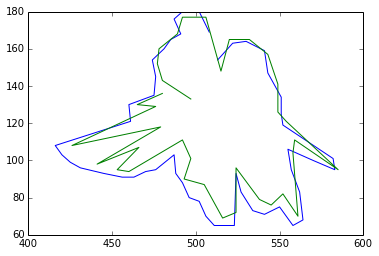

In [54]:
plt.plot(list(worker_x_locs),list(worker_y_locs))
plt.plot(list(my_x_locs),list(my_y_locs))

In [56]:
def MunkresEuclidean(obj_x_locs,obj_y_locs,numPts=50,PRINT=False):
    '''
    Given two worker's responses, 
    Compares Euclidean distances of all points in the polygon, 
    then find the best matching (min dist) config via Kuhn-Munkres
    '''
    if obj_x_locs[0]==obj_x_locs[1] and obj_y_locs[0]==obj_y_locs[1] :
        return 0
    interpolated_obj_x_locs,interpolated_obj_y_locs = parametric_interpolate(obj_x_locs,obj_y_locs,numPts=numPts,PLOT=PRINT)
    polygon1 = zip(interpolated_obj_x_locs[0],interpolated_obj_y_locs[0])
    polygon2 = zip(interpolated_obj_x_locs[1],interpolated_obj_y_locs[1])

    matrix = spatial.distance.cdist(polygon1,polygon2,'euclidean')
    
    m = Munkres()
    try:
        indexes = m.compute(np.ma.masked_equal(matrix,0))
        total = 0
        for row, column in indexes:
            value = matrix[row][column]
            total += value
            if PRINT: print '(%d, %d) -> %.2f' % (row, column, value)
        return total         
    except(ValueError):
        # When there are only two points
        print "ValueError"
        return -1
    except(IndexError):
        print "IndexError"
        return -1

In [57]:
MunkresEuclidean(obj_x_locs,obj_y_locs)

IndexError


-1

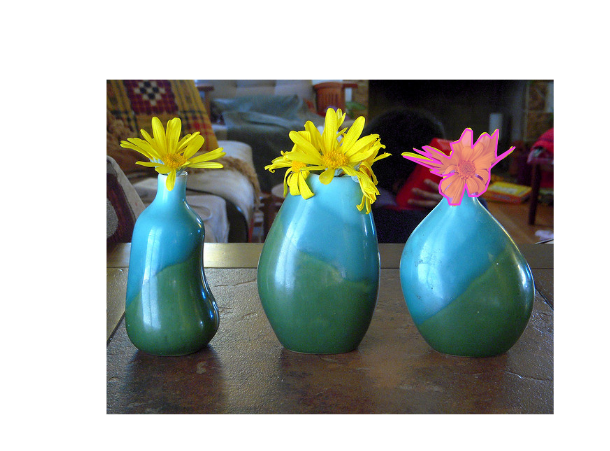

In [46]:
visualize_ground_truth_bb(29,'COCO')

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


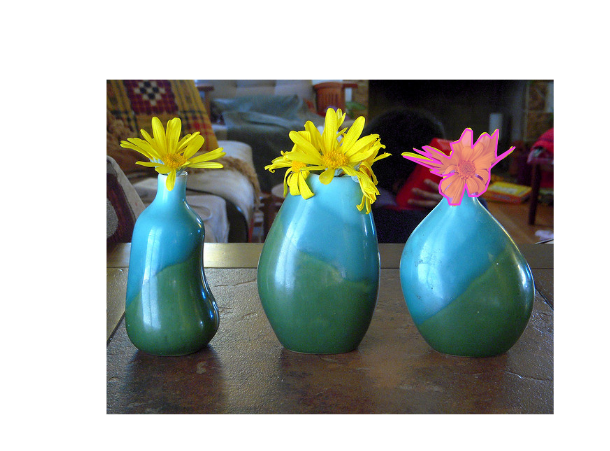

In [45]:
visualize_ground_truth_bb(29)

In [34]:
bb

(234,
 object_id                                                                  29
 worker_id                                                                 114
 x_locs                      [513, 522, 530, 541, 543, 551, 551, 552, 582, ...
 y_locs                      [154, 163, 164, 159, 147, 134, 125, 119, 101, ...
 Jaccard [Self]                                                            NaN
 Precision [Self]                                                          NaN
 Recall [Self]                                                             NaN
 Munkres Euclidean [Self]                                                  NaN
 Name: 234, dtype: object)

In [76]:
bb_info[bb_info.worker_id!=3]

,object_id,worker_id,x_locs,y_locs,Jaccard [Self],Precision [Self],Recall [Self],Munkres Euclidean [Self],Jaccard [COCO],Precision [COCO],Recall [COCO],Munkres Euclidean [COCO]
33,45,68,"[103, 105, 98, 71, 50, 44, 44, 72, 91, 98, 104]","[152, 204, 208, 208, 208, 200, 145, 135, 139, ...",0.830891,0.974006,0.849733,478.864414,NaN,NaN,NaN,NaN
38,20,4,"[488, 492, 413, 361, 347, 410]","[178, 354, 360, 331, 179, 177]",0.844888,0.905966,0.926102,1072.988403,NaN,NaN,NaN,NaN
39,18,6,"[107, 309, 312, 107]","[173, 170, 337, 343]",0.905598,0.976927,0.925391,1763.484688,0.890147,0.990753,0.897604,2099.885202
40,9,7,"[259, 258, 288, 299, 305, 352, 348, 354, 362, ...","[217, 268, 269, 284, 287, 282, 276, 273, 279, ...",0.920223,0.986032,0.932378,192.712811,0.939638,0.992749,0.946131,336.911117
41,13,7,"[255, 289, 296, 301, 301, 305, 302, 301, 307, ...","[269, 272, 278, 286, 294, 303, 318, 325, 328, ...",0.934818,0.975932,0.956878,416.938091,0.917241,0.985232,0.930028,380.293379
42,20,8,"[106, 305, 309, 114]","[172, 171, 333, 340]",0.000000,0.000000,0.000000,10530.041113,NaN,NaN,NaN,NaN
43,14,9,"[457, 463, 469, 477, 483, 492, 500, 514, 527, ...","[234, 219, 209, 198, 198, 207, 216, 210, 206, ...",0.904438,0.917531,0.984467,-1.000000,0.905317,0.950635,0.949977,-1.000000
44,12,8,"[300, 402, 387, 381, 333, 311, 309, 307]","[287, 436, 441, 439, 357, 327, 309, 320]",0.789606,0.973313,0.807079,443.162096,0.669440,0.974014,0.681614,803.113445
45,18,9,"[134, 196, 258, 308, 313, 306, 274, 264, 252, ...","[170, 170, 170, 169, 258, 330, 338, 337, 352, ...",0.954205,0.983064,0.970153,1150.437775,0.935394,0.995357,0.939493,552.220223
46,16,10,"[353, 420, 421, 421, 421, 419, 417, 414, 411, ...","[479, 479, 460, 452, 440, 428, 416, 406, 396, ...",0.916482,0.929674,0.984753,439.286467,0.863625,0.900619,0.954598,429.612637
